# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [68]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000  """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:44<00:00, 1993.42it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

# [4] Featurization

## [4.1] TF-IDF

In [24]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1), min_df=10,use_idf= True)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'abroad', 'absence']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 11524)
the number of unique words including both unigrams and bigrams  11524


# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [45]:
idf_score = tf_idf_vect.idf_  # obtaining the idf score from TFIDFVECTORIZER
feature_names  = tf_idf_vect.get_feature_names() # feature names for TFIDF

In [46]:
idfscore_feat =zip(idfScore,feature) 
idfscore_feat_sorted =sorted(idfscore_feat)# sorting the idfscore
top_6000_feat = idfscore_feat_sorted[:-(6000 + 1):-1] # taking the top 6000 features

In [47]:
top_6000_feat_names = [] # list of top 6000 features
# obtaining the top 6000 feature names
for i in range(len(top_6000_feat)):
    top_6000_feat_names.append(top_6000_feat[i][1])

print("Printing few top features of TFIDF vectorizer")
print(top_6000_feat_names[:50])

Printing few top features of TFIDF vectorizer
['yucca', 'yougurt', 'yell', 'yeasty', 'yamamotoyama', 'writeup', 'wondeful', 'witch', 'wiser', 'winn', 'wildlife', 'wil', 'wheats', 'werther', 'weber', 'wattage', 'washable', 'waring', 'walmarts', 'walgreen', 'waft', 'vue', 'viewed', 'veges', 'veal', 'vanillin', 'valve', 'vain', 'uplifting', 'unsweet', 'unsatisfying', 'uninterested', 'unilever', 'understands', 'uncommon', 'ultramix', 'uber', 'tweaking', 'turducken', 'turbinado', 'trusting', 'troops', 'trifle', 'transplant', 'traits', 'tout', 'tongues', 'tomatoe', 'tires', 'tinker']


### [5.2] Calulation of Co-occurrence matrix

In [28]:
# to obtain the co-occureence matrix using top 6000 features of TFIDF vectorizer
cooccurrenceMatrix = np.zeros((6000,6000)) # co-occurance matrix
context_window = 4 # context window for co-occurance matrix

In [48]:
#Calulating the co - occurance matrix
# Program to calculate the co-occurance matrix for each review.
for sent in tqdm(preprocessed_reviews): # obtaining each sentence of review
    words_sent = sent.split() # obtaining each word of a sent
    for index,word in enumerate(words_sent): # obtaining the index of each word from sentence
        if word in top_6000_feat_names: # checking whether the word is present in Top 6000
            for j in range(max(index - context_window,0),min(index + context_window , len(words_sent) -1) + 1):
                if words_sent[j] in top_6000_feat_names:
                    if words_sent[j] != word:
                        cooccurrenceMatrix[Top_2000.index(words_sent[j]), Top_2000.index(word)] += 1    
                    else:
                        pass
                else:
                    pass
        else:
            pass
           

100%|████████████████████████████████████████████████████████████████████████████| 87773/87773 [16:53<00:00, 86.60it/s]


### [5.3] Finding optimal value for number of components (n) to be retained.

Number of components = 4 and explained variance = 0.08216656240291377
Number of components = 10 and explained variance = 0.13897815923076795
Number of components = 15 and explained variance = 0.1757486157052782
Number of components = 20 and explained variance = 0.20393188107477758
Number of components = 50 and explained variance = 0.3137094940321737
Number of components = 100 and explained variance = 0.41985445607023264
Number of components = 150 and explained variance = 0.4907098939430049
Number of components = 200 and explained variance = 0.5410299232173459
Number of components = 500 and explained variance = 0.6879821873764532
Number of components = 700 and explained variance = 0.7443470266358965
Number of components = 800 and explained variance = 0.7674066690346224
Number of components = 900 and explained variance = 0.7879604729661822
Number of components = 1000 and explained variance = 0.8063923541212867
Number of components = 1500 and explained variance = 0.8767147856460058
Number

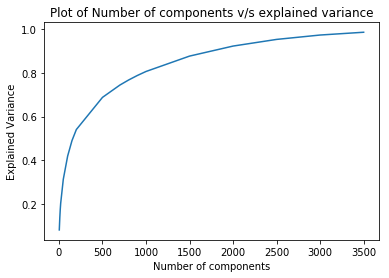

In [50]:
# Program to find the optimal number of components for Truncated SVD
n_comp = [4,10,15,20,50,100,150,200,500,700,800,900,1000,1500,2000,2500,3000,3500] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(cooccurrenceMatrix)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))

plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()
    

##### Optimal number of components is 3000. With number of components as 3000, we are able to have a explained variance about 97.2%

In [51]:
#Truncated SVD with number of components as 3000
svd = TruncatedSVD(n_components= 3000)
svd_6000 = svd.fit_transform(cooccurrenceMatrix)

### [5.4] Applying k-means clustering

In [34]:
# Program to perform K -means clustering 
def kcluster(x_train):
    """Function to perform Kmeans clustering on x_train"""
    num_clusters = [2,4,5,8,10] # number of clusters
    inertia = [] # to store inertia values
    #hyperparameter tunning to find the best number of clusters using inertia
    for num in num_clusters:
        clustering = KMeans(n_clusters= num,verbose= 0, n_jobs= -1,random_state= 0)# initialzing the kmeans clustering algorithm
        clustering.fit(x_train)
        inertia.append(clustering.inertia_ )
        print("For cluster = %r, inertia is = %r"%(num,clustering.inertia_ ))
    print(inertia)
    # to plot number of clusters v/s inertia
    plt.plot(num_clusters,inertia)
    plt.title('Plot of Number of clusters v/s Inertia')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()
    
    
def KmeansCluster(x_train, num_of_cluster,X = 'None',vectorizer = 'None'):
    """Function to perform Kmeans cluster and plot word cloud for each cluster
    Parameters:
    x_train : array-like or sparse matrix of shape = [n_samples, n_features], the training input samples
    
    num_of_cluster : number of cluster in clustering algorithm
    
    X =  array-like or sparse matrix of shape = [n_samples, n_features] Default = None. Required incase vectorizer in none, to plot word cloud for each cluster
    vectorizer : bag of words or TFIDF. Default = None.  
    
    """
    model = KMeans(n_clusters= num_of_cluster,verbose= 0, n_jobs= -1,random_state= 0)
    model.fit(x_train)
    sortedcentroids = model.cluster_centers_.argsort()[:,::-1] # sorting the cluster centroids
    word = [] # storing the words from each cluster for word cloud plotting
    # if vectorizer is present then get the get feature names from vectorizer for each cluster and store in word,
    # else obtain words for each cluster from each review belonging to that cluster
    if vectorizer != 'None':
        featureNames = vectorizer.get_feature_names()
        for i in range(num_of_cluster):
            sent = ' '
            for ind in sortedcentroids[i, :50]:
                sent += ' ' + featureNames[ind]
            word.append(sent)
    else:
        labels = model.labels_
        
        df = pd.DataFrame(data= X)
        df['labels'] = labels
        word = []
        for x in range(num_of_cluster):
            sent = ' '
            sent = sent.join(df[df.columns[0]][df['labels'] == x])
            word.append(sent)
    # To Plot word cloud for each review    
    for x in range(num_of_cluster):
        
        print("For cluster %r , the word cloud is as shown below"%x)
        print('-'*117)
        wordcloud_positive_words = WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10).generate(word[x]) 
        plt.figure(figsize = (8, 8), facecolor = None)
        plt.imshow(wordcloud_positive_words)
        plt.title("Word Cloud for cluster %r using Kmeans clustering"%x)
        plt.axis('off')
        plt.show()          
        print('='*117)
    

For cluster = 2, inertia is = 136076.38443321994
For cluster = 4, inertia is = 132650.41671716314
For cluster = 5, inertia is = 129342.22897683819
For cluster = 8, inertia is = 127528.41922766092
For cluster = 10, inertia is = 125828.70565209528
[136076.38443321994, 132650.41671716314, 129342.22897683819, 127528.41922766092, 125828.70565209528]


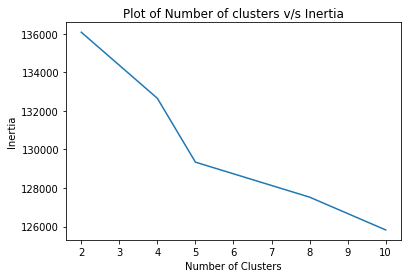

In [35]:
#k-means cluster
kcluster(svd_6000)

###### optimal number of cluster = 10

### [5.5] Wordclouds of clusters obtained in the above section

For cluster 0 , the word cloud is as shown below
---------------------------------------------------------------------------------------------------------------------


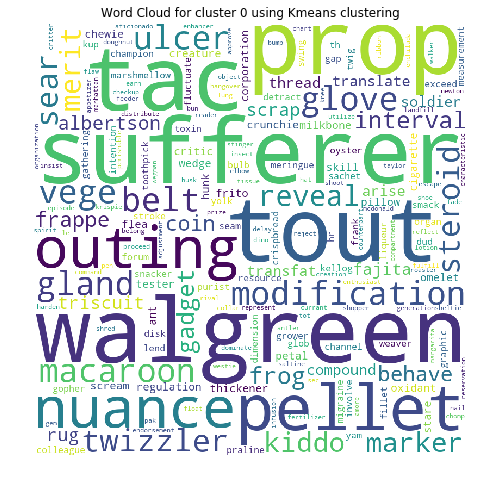

For cluster 1 , the word cloud is as shown below
---------------------------------------------------------------------------------------------------------------------


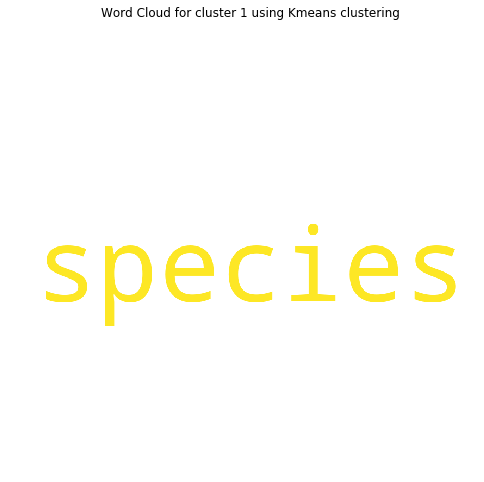

For cluster 2 , the word cloud is as shown below
---------------------------------------------------------------------------------------------------------------------


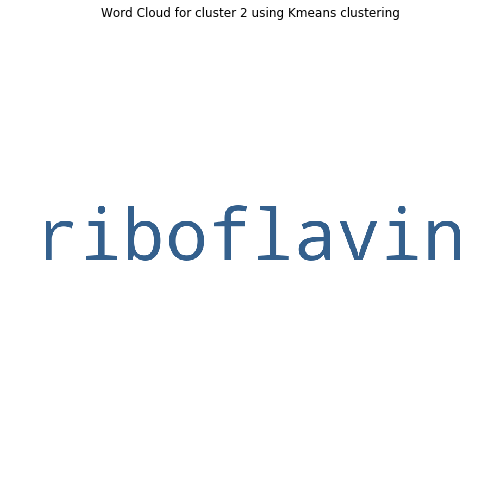

For cluster 3 , the word cloud is as shown below
---------------------------------------------------------------------------------------------------------------------


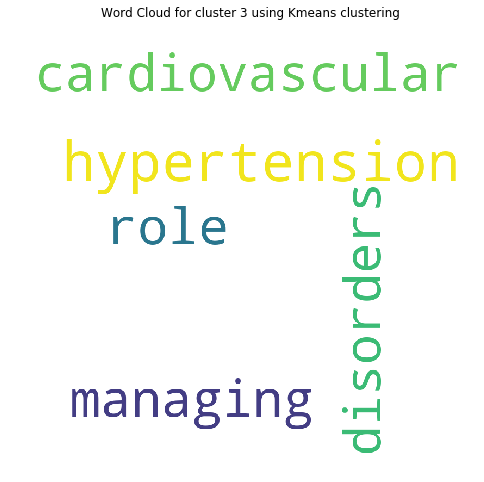

For cluster 4 , the word cloud is as shown below
---------------------------------------------------------------------------------------------------------------------


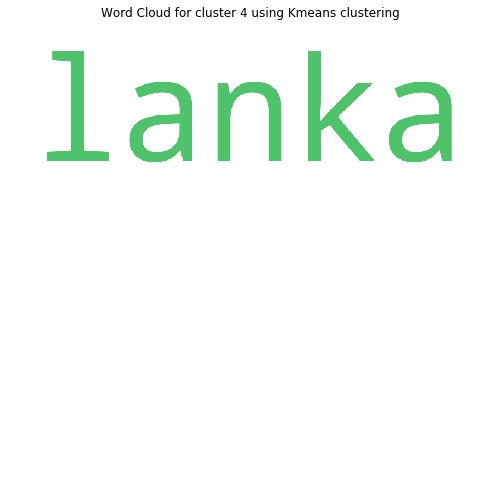

For cluster 5 , the word cloud is as shown below
---------------------------------------------------------------------------------------------------------------------


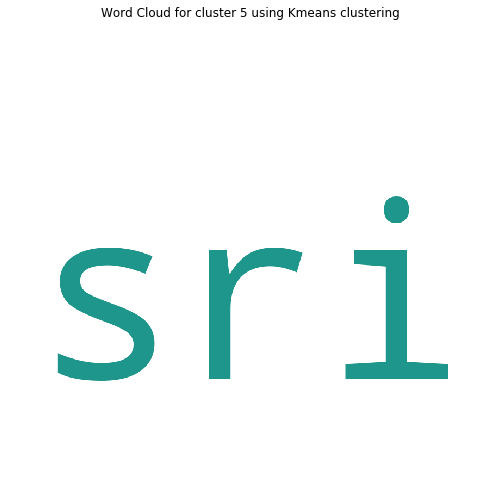

For cluster 6 , the word cloud is as shown below
---------------------------------------------------------------------------------------------------------------------


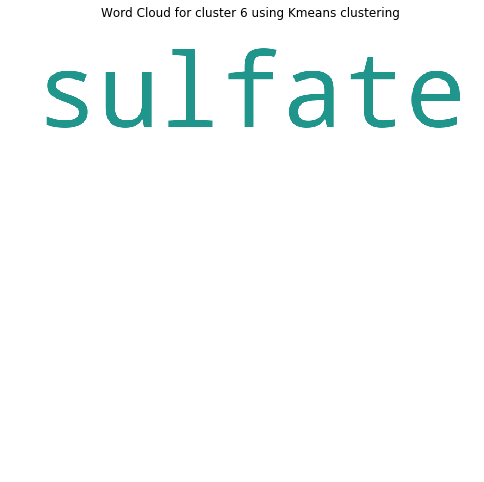

For cluster 7 , the word cloud is as shown below
---------------------------------------------------------------------------------------------------------------------


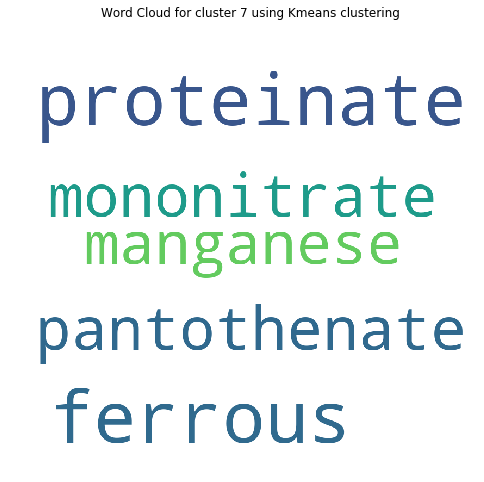

For cluster 8 , the word cloud is as shown below
---------------------------------------------------------------------------------------------------------------------


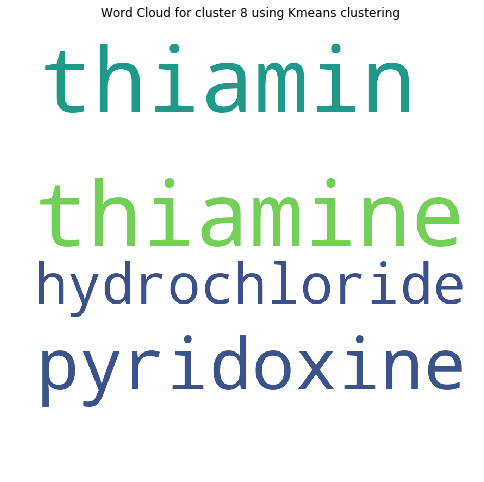

For cluster 9 , the word cloud is as shown below
---------------------------------------------------------------------------------------------------------------------


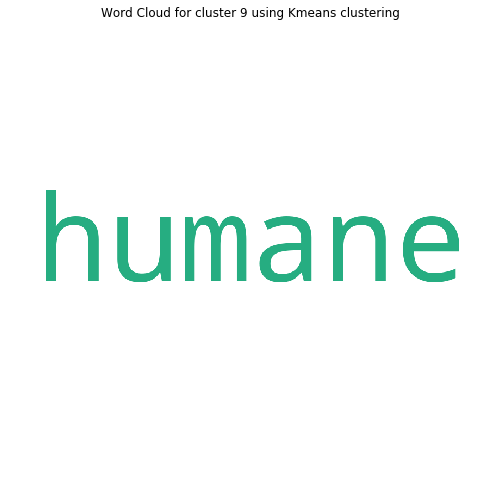

In [36]:
# Word for each cluster
KmeansCluster(svd_200,10,top_6000_feat_names)

### [5.6] Function that returns most similar words for a given word.

In [65]:
#Obtaining the cosine similarity
def similarWords(word,number = 20):
    """Function to provide the most similar words for a given word
    Parameters:
    word: word whoes similar words needs to be determined
    number : numbers of most similar words to word to display.Default = 20
    
    
    """
    simi = cosine_similarity(svd_6000) # similarity matrix using cosine similarity
    try:
        word_vec = simi[top_6000_feat_names.index(word)] # vector for the given word
        index = np.argsort(word_vec, axis= -1) # index of top words similar to the given word
        similar_words_ = [] # list containing the top similar words
        for x in index[:number]:
            similar_words_.append(top_6000_feat_names[x])
        print("%r most similar words to %r are given below"%(number,word))
        print(similar_words_)
    except:
        print("Please provide a different word.")        

In [67]:
#Program to find the 30 most similar words.
similarWords('tinker',30)

30 most similar words to 'tinker' are given below
['vox', 'similarity', 'glossary', 'boullion', 'terrified', 'foams', 'squashed', 'heap', 'tony', 'edamame', 'pirates', 'aisles', 'invoice', 'fatal', 'nutritive', 'curve', 'hardcore', 'lasagne', 'leaner', 'periodic', 'imitations', 'tenth', 'households', 'pocketbook', 'remarks', 'portioned', 'caraway', 'inexpensively', 'accompanies', 'soymilk']


# [6] Conclusions

# Observations: 

1] The IDF score is very high for those words which are very rare in the document. Few of these words are displayed a
above in the notebook.  For example: yucca', 'writeup', 'wondeful', 'witch','tinker', etc  
2] All the diagonal elements of co-occurance matrix is zero.  
3] some of the cluster obtained using k-means have very few words. All words with similar meaning are grouped together in the clusters.

### Optimal number of components of Truncated svd was 3000, wherein the explained variance was above 97%.
### Optimal number of clusters obtained using K-means clustering algorithm was 10.